# Q-Learning experiment runner

## Imports

In [1]:
%%capture
!pip install tqdm

In [67]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import copy
from operator import itemgetter
from contextlib import redirect_stdout
from datetime import datetime

from typing import Tuple, Any

In [3]:
from q_maze import QMaze, Action
from e_greedy_policy import EGreedyPolicy
from qlearning import QLearning

from qlearning_exp_functions import Results, train_ql_for_one_episode, run_ql_experiments
from utils import stringify_dict, preprocess_hyperparameters_filename

## Smoke test for QMaze, EGreedyPolicy and running on one episode

In [10]:
qm = QMaze(10)
# Reminder that QMaze.reset only returns agent state now.
# Be careful to capture the state when resetting, because the 
# Agent/entrance will move!
state = qm.reset()
eg_policy = EGreedyPolicy(epsilon=0.5, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)


In [11]:
qm.display(debug=True)

X X X X X X X X X X 
X . . X A . X X . X 
X X . X X . . . . X 
X . . . X X X . X X 
X X X . X . X . . X 
X . . . X . . . X X 
X X X . X X X . . X 
X . . . . . X . X X 
X . X . X . . . . X 
X X X X X X X X O X 

{'maze_width': 10, 'maze_height': 10, 'size': 10, 'has_treasure': False, 'treasure_found': 0, 'treasure_left': 0, 'treasure_map': [], 'position_agent': (1, 4), 'position_entrance': (1, 4), 'position_exit': (9, 8), 'maze': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 1, 2, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 3, 1]]), 'generation_start_coords': (8, 7), 'generation_start_neighbours': [], 'turns_elapsed': 0, 'done': False, 'coord_to_index_state': array([[27, 46, 95, 50, 74, 84, 90,  0, 37, 97

### One iteration to check policy is working with QLearning

113
-480


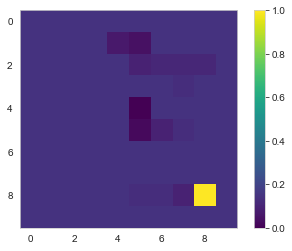

In [12]:
done = False
total_reward = 0

while not done:
    next_action = eg_policy(state, ql.q_value_store)
    next_state, reward, done = qm.step(next_action)
    next_action_index = next_action.value.index
    
    ql.update_q_values(
        current_state=state,
        next_action=next_action_index,
        next_reward=reward,
        next_state=next_state
    )

    eg_policy.update_epsilon()
    state = next_state
    total_reward += reward

print(qm.turns_elapsed)
print(total_reward)
vals = ql.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();

In [15]:
# The maze is solved
qm.display()

X X X X X X X X X X 
X . . X I . X X . X 
X X . X X . . . . X 
X . . . X X X . X X 
X X X . X . X . . X 
X . . . X . . . X X 
X X X . X X X . . X 
X . . . . . X . X X 
X . X . X . . . . X 
X X X X X X X X A X 



## Run for more episodes

Parameterise:
- epsilon for e-greedy
- gamma - discount factor
- alpha - learning rate or memory
- size of maze
- max reward
- decay - constant decay of epsilon

In [4]:
# Some plotting functions which must live here
# because of notebook functionality.
def plot_mean_rewards_episodes(episode_idx: int, experiment_mean_rewards: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last mean reward of {experiment_mean_rewards[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean reward")
    plt.plot(experiment_mean_rewards)
    plt.show()

def plot_turns_elapsed_episodes(episode_idx: int, experiment_mean_turns_elapsed: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last turns elapsed of {experiment_mean_turns_elapsed[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean turns elapsed")
    plt.plot(experiment_mean_turns_elapsed)
    plt.show()

In [5]:
qm = QMaze(10)
eg_policy = EGreedyPolicy(epsilon=0.6, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)

LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 1000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = 1000//LOGGING_STEP_SIZE

# Create structure to store data
all_results: list = []

# Plot rewards and turns elapsed
experiment_mean_rewards: list = []
experiment_mean_turns_elapsed: list = []

for run in NUM_RUNS_TQDM:
    if ((run % LOGGING_STEP_SIZE) == 0) or (run == 1):
        results = run_ql_experiments(environment=qm, policy=eg_policy, q_learning_method=ql, num_episodes=NUM_LOGGED_EPISODES)
        print(f"Run: {run}, ending epsilon: {eg_policy.epsilon}, mean reward: {results.mean_reward}, mean turns elapsed: {results.mean_turns_elapsed}, std reward: {results.var_reward}")
        all_results.append(results)
        experiment_mean_rewards.append(results.mean_reward)
        experiment_mean_turns_elapsed.append(results.mean_turns_elapsed)

        # Plot mean turns elapsed live
        plt.plot(experiment_mean_turns_elapsed);
        plt.title(f"Mean turns elapsed for {NUM_EPISODES} episodes");
        plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
        plt.ylabel("Mean turns elapsed");
        plt.ylim([0, 1000]);
        plt.xlim([0, LOGGING_STEP_SIZE]);



  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: run_ql_experiments() missing 1 required positional argument: 'hyperparameter_dict'

X X X X X X X X X X 
X X X . . . X A . X 
X X . . X . . . X X 
X . . X X X X . X X 
X X X X . . . . . X 
X . . . . X X . X X 
X X X X X X . . . X 
X X X X X X . X . X 
X . . . . . . X . X 
X X X X X X X X O X 



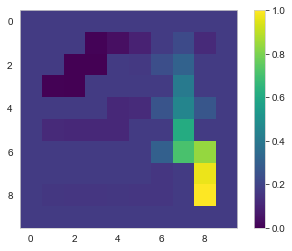

In [10]:
qm.reset()
qm.display()
results_vals = ql.display_q_values()
plt.imshow((results_vals - results_vals.min())/(results_vals.max() - results_vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();


In [ ]:
# Plot rewards
plt.plot(experiment_mean_rewards);
plt.title(f"Mean rewards for {NUM_EPISODES} episodes");
plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
plt.ylabel("Reward");
plt.ylim([-1000, 200]);
plt.xlim([0, LOGGING_STEP_SIZE]);

In [68]:
def train_on_qlearning(
    env_size: int,
    epsilon: float,
    decay: float,
    gamma: float,
    alpha: float,
    num_runs_tqdm: Any,
    logging_step_size: int,
    num_logged_episodes: int,
    num_episodes: int,
    output_path: str
) -> None:

    qm = QMaze(env_size)
    eg_policy = EGreedyPolicy(epsilon=epsilon, decay=decay)
    ql = QLearning(policy=eg_policy, environment=qm, gamma=gamma, alpha=alpha)

    # Create structure to store data
    all_results: list = []

    # Plot rewards and turns elapsed
    experiment_mean_rewards: list = []
    experiment_mean_turns_elapsed: list = []

    # Collect hyperparameter information
    HYPERPARAMETER_DICT = {
        "env_size": env_size,
        "epsilon": epsilon,
        "decay": decay,
        "gamma": gamma,
        "alpha": alpha  
    }
    HYPERPARAMETER_OUT = stringify_dict(HYPERPARAMETER_DICT)
    HYPERPARAMETER_FILE_NAME = preprocess_hyperparameters_filename(HYPERPARAMETER_DICT)
    FILE_NAME = HYPERPARAMETER_FILE_NAME
    PLOT_FILE_NAME = FILE_NAME

    # Save rendered maze
    with open(os.path.join(OUTPUT_PATH, "maze_layout.txt"), "w") as f:
        with redirect_stdout(f):
            qm.display(debug=True)

    for run in NUM_RUNS_TQDM:
        if ((run % LOGGING_STEP_SIZE) == 0) or (run == 1):
            results = run_ql_experiments(
                environment=qm,
                policy=eg_policy,
                q_learning_method=ql,
                num_episodes=NUM_LOGGED_EPISODES,
                hyperparameter_dict=HYPERPARAMETER_DICT
            )
            print(f"Run: {run}, ending epsilon: {eg_policy.epsilon}, mean reward: {results.mean_reward}, mean turns elapsed: {results.mean_turns_elapsed}, std reward: {results.var_reward}")
            all_results.append(results)
            experiment_mean_rewards.append(results.mean_reward)
            experiment_mean_turns_elapsed.append(results.mean_turns_elapsed)

    # Save detailed results
    individual_results_df = pd.DataFrame(all_results)
    individual_results_df.to_csv(os.path.join(OUTPUT_PATH, HYPERPARAMETER_FILE_NAME + ".csv"), index=False)

    # Save mean reward plot
    sns.lineplot(data=experiment_mean_rewards);
    plt.title(f"Mean rewards over {NUM_EPISODES} episodes")
    plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
    plt.ylabel("Mean reward");
    # plt.xlim([0, LOGGING_STEP_SIZE]);
    
    # last_mean_reward = (NUM_RUNS, experiment_mean_rewards[-1])
    # enumerated_mean_rewards = list(enumerate(experiment_mean_rewards))
    # min_mean_reward = min(enumerated_mean_rewards, key=lambda i: i[1])
    # max_mean_reward = max(enumerated_mean_rewards, key=lambda i: i[1])

    # plt.annotate(f"Last {last_mean_reward[1]}", last_mean_reward)
    # plt.annotate(f"Min {min_mean_reward[1]}", min_mean_reward)
    # plt.annotate(f"Max {max_mean_reward[1]}", max_mean_reward)

    plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_mean_rewards.png"), dpi=300, bbox_inches="tight");
    plt.show();

    # Save mean turns elapsed plot
    sns.lineplot(data=experiment_mean_turns_elapsed);
    plt.title(f"Mean turns elapsed over {NUM_EPISODES} episodes");
    plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
    plt.ylabel("Mean turns elapsed");
    # plt.xlim([0, LOGGING_STEP_SIZE]);

    # last_mean_turns_elapsed = (NUM_RUNS, experiment_mean_turns_elapsed[-1])
    # enumerated_mean_turns_elapsed = list(enumerate(experiment_mean_turns_elapsed))
    # min_mean_turns_elapsed = min(enumerated_mean_turns_elapsed, key=lambda i: i[1])
    # max_mean_turns_elapsed = max(enumerated_mean_turns_elapsed, key=lambda i: i[1])

    # plt.annotate(f"Last {last_mean_turns_elapsed[1]}", last_mean_turns_elapsed)
    # plt.annotate(f"Min {min_mean_turns_elapsed[1]}", min_mean_turns_elapsed)
    # plt.annotate(f"Max {max_mean_turns_elapsed[1]}", max_mean_turns_elapsed)

    plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_mean_turns_elapsed.png"), dpi=300, bbox_inches="tight");
    plt.show();

    # Save heatmap
    results_vals = ql.display_q_values()
    plt.imshow((results_vals - results_vals.min())/(results_vals.max() - results_vals.min()), cmap="viridis")
    plt.colorbar()
    plt.grid(False)
    plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_q_values.png"), dpi=300, bbox_inches="tight");
    plt.show();
    
    # Write to datetime run's results summary
    results_summary = copy.deepcopy(HYPERPARAMETER_DICT)
    results_summary.update({
        "experiment_mean_rewards": experiment_mean_rewards,
        "experiment_mean_turns_elapsed": experiment_mean_turns_elapsed
    })
    print(results_summary)
    results_summary_df = pd.DataFrame.from_dict(results_summary)
    # Append result summary to overall file.
    # Creates this csv if doesn't exist, 
    # adds header if being created, otherwise skip.
    with open(os.path.join(OUTPUT_PATH, "results_summary.csv"), "a") as f:
        results_summary_df.to_csv(f, header=f.tell()==0, index=False)
    

 61%|██████    | 61/100 [00:10<00:02, 16.63it/s]Run: 50, ending epsilon: 0.0900567811781995, mean reward: -49.6, mean turns elapsed: 36.56, std reward: 570.5311910842387
Run: 60, ending epsilon: 0.0900567811781995, mean reward: 34.47, mean turns elapsed: 17.55, std reward: 24.733157905936718
100%|██████████| 100/100 [00:10<00:00,  9.25it/s]Run: 90, ending epsilon: 0.0900567811781995, mean reward: 41.51, mean turns elapsed: 16.38, std reward: 20.068629748939014



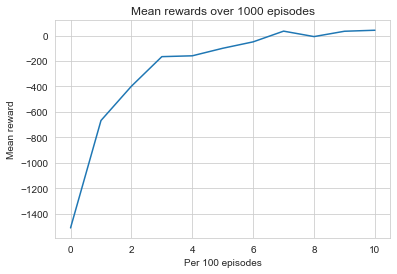

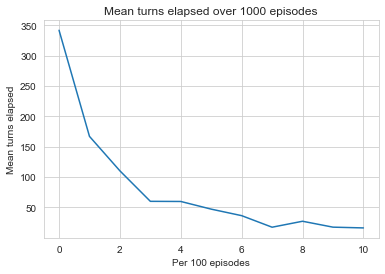

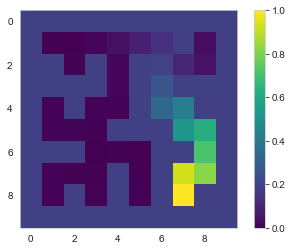

None


TypeError: cannot unpack non-iterable NoneType object

In [66]:
# Logging stuff
RESULTS_PATH = "results"
dt_now = datetime.now()
dt_str = dt_now.strftime("%Y%m%d-%H%M%S")

OUTPUT_PATH = os.path.join(RESULTS_PATH, dt_str)

if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 1000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = 1000//LOGGING_STEP_SIZE

ENV_SIZE_LIST = [10]
EPSILON_LIST = [0.6]
DECAY_LIST = [0.9]
GAMMA_LIST = [0.9]
ALPHA_LIST = [0.01]

for env_size in ENV_SIZE_LIST:
    for epsilon in EPSILON_LIST:
        for decay in DECAY_LIST:
            for gamma in GAMMA_LIST:
                for alpha in ALPHA_LIST:
                    (
                        hyperparameter_dict,
                        all_results,
                        experiment_mean_rewards,
                        experiment_mean_turns_elapsed,
                    ) = train_on_qlearning(
                        env_size=env_size,
                        epsilon=epsilon,
                        decay=decay,
                        gamma=gamma,
                        alpha=alpha,
                        num_runs_tqdm=NUM_RUNS_TQDM,
                        logging_step_size=LOGGING_STEP_SIZE,
                        num_logged_episodes=NUM_LOGGED_EPISODES,
                        num_episodes=NUM_EPISODES,
                        output_path=OUTPUT_PATH
                    )



## Test QMaze number of steps for different environment sizes